<a href="https://colab.research.google.com/github/DongDong-Zoez/pytorchAI/blob/main/ExplainableAI/GradCAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Grad-CAM

我們之所以能夠判斷一張影像屬於哪一個類別，是因為我們能夠抓住影像的特徵，我們在前文 [Segmentataion](https://github.com/DongDong-Zoez/pytorchAI/blob/main/CNN/Segmentation.ipynb) 提過神經網路的 CNN 層會提取特徵，那們我們要怎麼知道這些特徵到底在提取什麼? 在 2016 年有專家提出 Grad-CAM 來視覺化神經網路抓取的特徵熱圖，想要了解 Grad-CAM，我們先來看看 CAM (Class Activation Mapping)

## CAM

[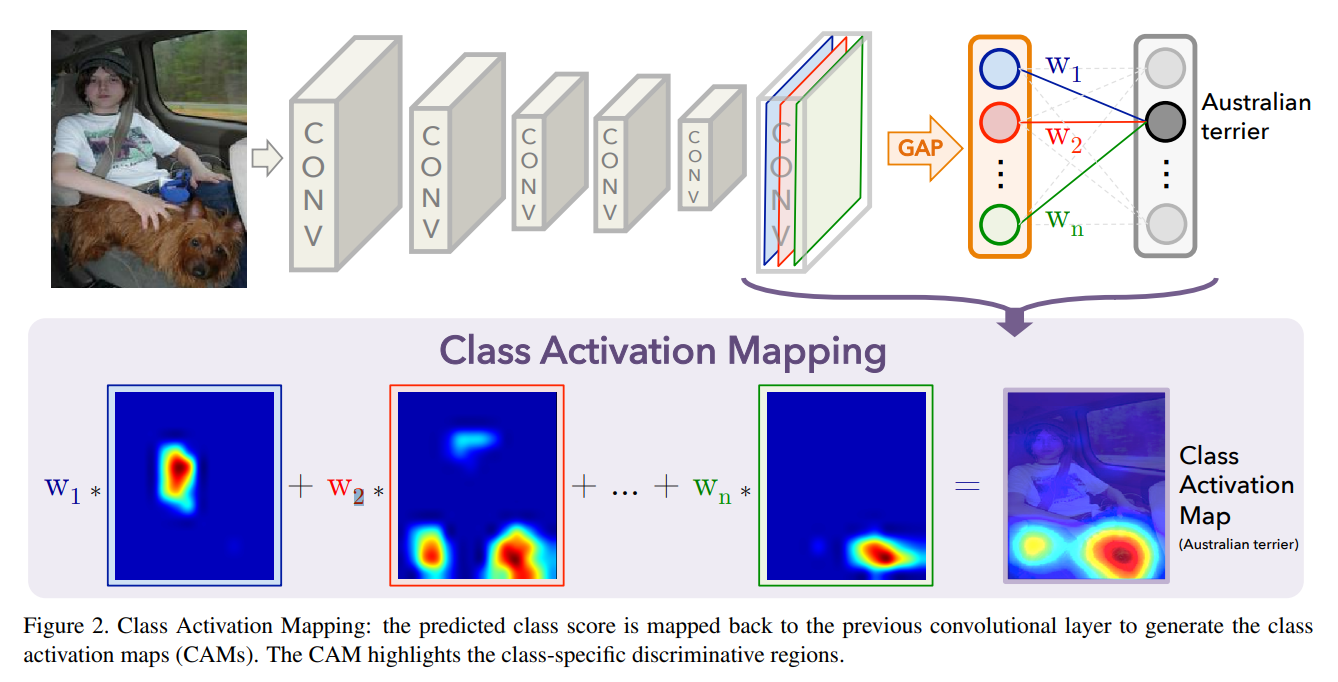]()

回想我們統計學過的方法，舉凡線性回歸、羅吉斯回歸、典型相關分析、線性判別分析等等方法，如果想知道某個特徵對於我們的變量影響有多大，那麼我們會怎麼做?

<details>
<summary>點擊揭曉答案!!</summary>
沒錯，就是看該特徵前面的權重係數大小
</details>

如果特徵前係數絕對值越大代表該特徵越能夠影響我們的反應變量，如果寫成數學的方式

$$
\beta_0 + \beta_1x_1 + \cdots + \beta_px_p = y
$$

$|\beta_i|$ 越大則 $x_i$ 越能夠影響 $y$

我們說神經網路的 classifier 其實也是一個羅吉斯回歸，所以我們也可以用相同方法看待神經網路，注意到在上圖中 Conv 蒐集出的特徵圖會通過一個運算 GAP (Global Average Pooling) 用來節取所有特徵的信息，那麼 GAP 在做的事情其實就是 $(bs, c', h', w')$ 對 $(h', w')$ 這個維度做平均，也就是把一個特徵圖的值全部加總平均 $[(bs, c', h', w') \to (bs, c', 1, 1)]$

在我濃縮所有信息之後，我會在最後一層加上 nn.Linear(c',n) 和 softmax 做為 classifier，nn.Linear 學到的參數 $(w_1, \cdots, w_n)$ 某種程度上代表了每個特徵圖的重要性，我們把所有特徵圖乘上權重後加總就得到我們的熱圖啦

## 有什麼問題

CAM 是一個很好的想法，但是不是每個神經網路特徵提取最後一層都會接上 GAP，這樣做的泛化性不大，所以 Grad-CAM 強調使用特徵圖的梯度做為權重，而非使用 GAP

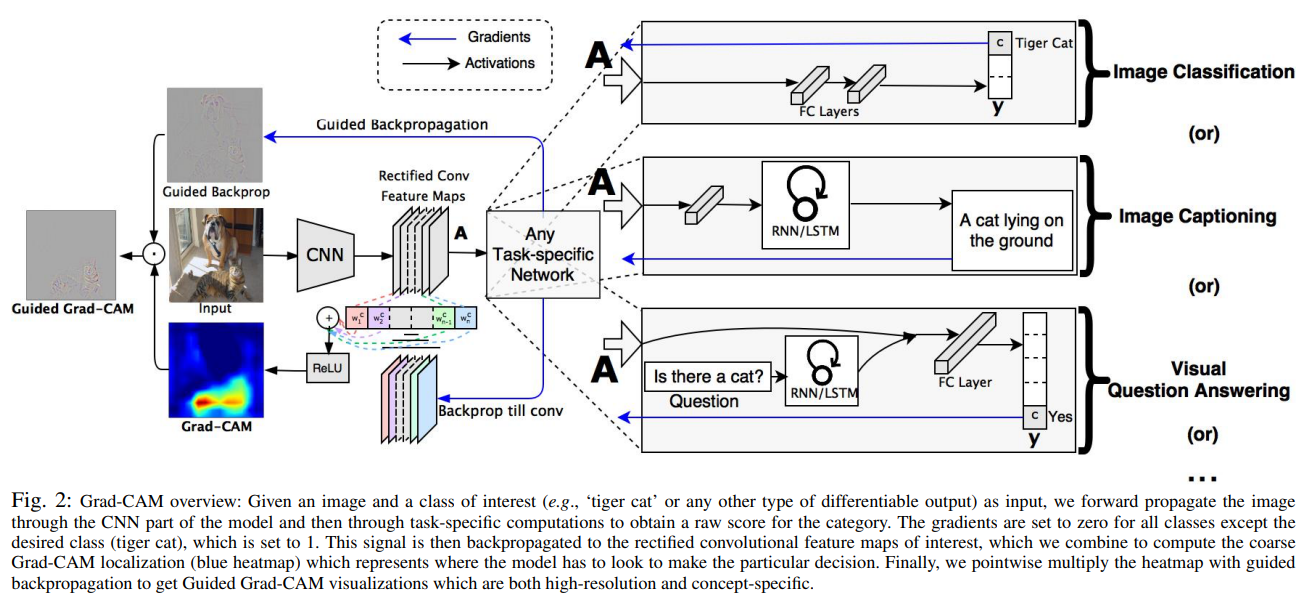

可以看到不管你的任務是什麼 Grad-CAM 都可以使用神經網路提取到的特徵計算反向傳播的梯度得到特徵梯度圖，其大小為 $(bs,c',h',w')$ 同樣的，我們對 $(h',w')$ 維度做平均，再把特徵圖上乘得到的係數，最後再用上採樣方法還原影像原本的大小

### 流程

1. 將影像放入模型中前向傳播
2. 把某一層的特徵圖取出
3. 對該特徵圖計算梯度
4. 把每個特徵圖的梯度做加總平均
5. 對特徵圖做上採樣
6. 上採樣過後乘上權重

以下我們以 github 套件 [grad-cam](https://github.com/jacobgil/pytorch-grad-cam) 示範範例程式碼

In [ ]:
!pip install grad-cam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 23.0 MB 29.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.0-py3-none-any.whl size=28155 sha256=5eef1c0274d803589762c955a722ccc6b57ff803988eb3c42f6f090e3a040817
  Stored in directory: /root/.cache/pip/wheels/a5/dd/4c/8a6ae2754b8c2fa442c78ce0eee39c14dc8e21cb3d27604ec2
Successfully built grad-cam


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import cv2
import torch

image = cv2.imread('/content/gdrive/MyDrive/pytorchAI/roger.jpg')

image = torch.FloatTensor(image)
image = image.permute(2,1,0).unsqueeze(0)
np_image = image.squeeze(0).permute(1,2,0).data.numpy() / 255

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50

model = resnet50(pretrained=True)
target_layers = [model.layer4[-1]]
input_tensor = image
# Note: input_tensor can be a batch tensor with several images!

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers, use_cuda='cuda')

# You can also use it within a with statement, to make sure it is freed,
# In case you need to re-create it inside an outer loop:
# with GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda) as cam:
#   ...

# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.

# This parameter is to indicate which class label should be considered.
# If None, then highest scoring class label is utilized.
#targets = [ClassifierOutputTarget(281)]
targets = None

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(np_image, grayscale_cam, use_rgb=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


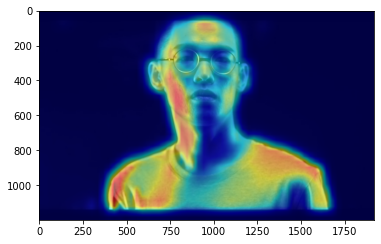

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(visualization.transpose(1,0,2))

除了 Grad-CAM 之外，近幾年也陸陸續續產生了一些新的方法，如 Gram-CAM++，ScoreCAM 等等，當影像有多類別的物件時，Grad-CAM 往往無法發揮出好的結果

在可解釋 AI 中大致可分為

- gradient-based
  - Gram-CAM
  - Gram-CAM++
- gradient-free
  - Score-CAM

在往後的幾個章節我們會重點介紹其他的可解釋 AI 模型